In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
import os
from sklearn.model_selection import train_test_split, StratifiedKFold
from sktime.forecasting.model_selection import SlidingWindowSplitter
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.pipeline import make_pipeline, Pipeline
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import multiprocessing

In [8]:
rs=121
stocks=['aapl','googl','nvda','dal','xom','cvx','vz']

In [9]:
init_dir_path = str(os.getcwd())
data=pd.read_csv(init_dir_path+'/stock_hmm_output.csv',engine='python').drop(['Unnamed: 0'],axis=1)
features=['Return','Volatility','HighR','LowR']
target='State'
#train, test = train_test_split(data,test_size=0.2,shuffle=True,random_state=rs,stratify=data['State'])

In [4]:
#With TimeSeries
#First Set Aside Testing data
final_test=[]
stocks_data=[]
ft_size=400
for x in data.groupby(['Ticker']):
    final_test.append(x[1][-ft_size:])
    stocks_data.append(x[1][:-ft_size])
#Model Training
#model=
#model.fit(x=train_x,y=train_y)
#Model Prediction and Accuracy
#accuracy_score(test_y,model.predict(test_x))


In [102]:
def create_sliding_window(train_df, test_df, features, target, window=7):
    splitter = SlidingWindowSplitter(window_length=window, step_length=1, fh=[1])
    train_x, train_y, test_x, test_y = [], [], [], []

    for idx in splitter.split(train_df):
        X = train_df.iloc[idx[0]][features].values.flatten()
        y = train_df.iloc[idx[1]][target].values.flatten()[0]
        train_x.append(X)
        train_y.append(y)

    for idx in splitter.split(test_df):
        X = test_df.iloc[idx[0]][features].values.flatten()
        y = test_df.iloc[idx[1]][target].values.flatten()[0]
        test_x.append(X)
        test_y.append(y)

    return (train_x, train_y), (test_x, test_y)


In [10]:
testing_size=500
ns=5
tss=TimeSeriesSplit(n_splits=ns,test_size=testing_size)
spread_range = range(2, 25)

Skip the three cells below if you have access to the saved training windows

training_lists is a dictionary with keys as spread, that is window size for model fitting.

training_list is a dictionary which gets assigned as value for training_lists.

training_list is a dictionary with stocks as keys and values as list. This list is nested as consists of pairs.

For ex, training_lists[3] would be a dictionary showing stock-wise rolling windows.

training_lists[3][0] would consist of a nested list, associated to rolling windows of size 3 and for the Apple stock.

training_lists[3][0] = [rolling windows for training (each of them is a list),rolling state for the next day(each of them a singleton list)]

In [ ]:
training_lists = {}
testing_lists = {}
for spread in spread_range:
    training_lists[spread] = {}
    testing_lists[spread] = {}
    for ticker_idx, ticker_df in enumerate(stocks_data):
        ticker = list(ticker_df["Ticker"])[0]
        training_list = [[[], []] for _ in range(ns)]
        testing_list = [[[], []] for _ in range(ns)]
        for fold_idx, (train_idx, test_idx) in enumerate(tss.split(ticker_df)):
            train_df = ticker_df.iloc[train_idx]
            test_df = ticker_df.iloc[test_idx]           
            (train_x, train_y), (test_x, test_y) = create_sliding_window(train_df, test_df, features, target, window=spread)
            training_list[fold_idx][0] += train_x
            training_list[fold_idx][1] += train_y
            testing_list[fold_idx][0] += test_x
            testing_list[fold_idx][1] += test_y
        training_lists[spread][stocks.index(ticker)] = training_list
        testing_lists[spread][stocks.index(ticker)] = testing_list #spread->stock index->time series split->data/label

In [117]:
with open('saved_training_lists.pkl', 'wb') as f:
    pickle.dump(training_lists, f)

with open('saved_testing_lists.pkl', 'wb') as f:
    pickle.dump(testing_lists, f)

Load training, test windows here. 
They're saved for complexity reasons, RUN CODE from here

In [11]:
with open('saved_training_lists.pkl', 'rb') as f:
    training_lists = pickle.load(f)

with open('saved_testing_lists.pkl', 'rb') as f:
    testing_lists = pickle.load(f)

In [7]:
import optuna
def objective_with_args(spread, stock_ind):
    def inner(trial):
        param = {
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
            'n_estimators': trial.suggest_int('n_estimators', 100, 300),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'reg_alpha': trial.suggest_categorical('reg_alpha', [0, 0.1, 0.5, 1.0]),
            'reg_lambda': trial.suggest_categorical('reg_lambda', [0.5, 1.0, 2.0, 5.0]),
            'min_split_loss': trial.suggest_categorical('min_split_loss', [0, 0.1, 0.3, 0.5]),
            "tree_method": "hist",
            "device": "cuda",
        }
        model = XGBClassifier(**param)
        a = 0
        training_list = training_lists[spread][stock_ind]
        testing_list = testing_lists[spread][stock_ind]
        for i in range(ns):
            model.fit(X=training_list[i][0], y=training_list[i][1])
            a += accuracy_score(model.predict(testing_list[i][0]), testing_list[i][1])
        a = a / ns
        return a
    return inner


from functools import partial

best_XGB = {}
for spread in spread_range:
    best_XGB[spread] = {}
    for s_ind in range(len(stocks)):
        study = optuna.create_study(direction="maximize")
        study.optimize(objective_with_args(spread, s_ind), n_trials=50)
        
        best_params = study.best_params
        best_XGB[spread][s_ind] = XGBClassifier(**best_params, tree_method="hist", device="cuda")

[I 2025-04-12 18:31:06,296] A new study created in memory with name: no-name-bb736c09-c454-483e-83eb-89554ea0416a
c:\Users\18585\anaconda3\envs\erdos_spring_2025\Lib\site-packages\xgboost\core.py:729: UserWarning: [18:31:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)
[I 2025-04-12 18:31:10,782] Trial 0 finished with value: 0.8405622489959839 and parameters: {'max_depth': 8, 'learning_rate': 0.16274639538102562, 'n_estimators': 238, 'subsample': 0.5518832468783684, 'colsample_bytree': 0.7737469846215037, 'reg_alpha': 0, 'reg_lambda': 2.0, 'min_split

In [20]:
with open('saved_xgb.pkl', 'rb') as f:
    best_XGB=pickle.load(f)

In [12]:
def accuracies_model(model_dict, window, stock_ind, map=True):
    a=0
    conf_mat=np.zeros((2,2))
    if map:
        model = model_dict[window][stock_ind]
    else:
        model = model_dict
    for i in range(ns):
        model.fit(X=training_lists[window][stock_ind][i][0],y=training_lists[window][stock_ind][i][1])
        y_pred=model.predict(testing_lists[window][stock_ind][i][0])
        y_true=testing_lists[window][stock_ind][i][1]
        a+= accuracy_score(y_true,y_pred)
        conf_mat=conf_mat+confusion_matrix(y_true=y_true,y_pred=y_pred)
    a=a/ns
    return (a,conf_mat)

def accuracies_model(model_dict, window, stock_ind, map=True):
    a=0 
    if map:
        model = model_dict[window][stock_ind]
    else:
        model = model_dict
    for i in range(ns):
        model.fit(X=training_lists[window][stock_ind][i][0],y=training_lists[window][stock_ind][i][1])
        a+= accuracy_score(model.predict(testing_lists[window][stock_ind][i][0]),testing_lists[window][stock_ind][i][1])
    a=a/ns
    return a

In [13]:
def plot_accuracies(accuracies, model_type, acc_type="accuracy"): #accuracies needs to be a nested dictionary window->stock index
    for stock_ind in range(len(stocks)):
        vals = []
        for window in accuracies.keys():
            vals.append(accuracies[window][stock_ind])
        plt.figure(figsize=(6, 4))
        plt.plot(list(accuracies.keys()), vals, marker='o')
        plt.title(f"{model_type} accuracy scores for {stocks[stock_ind]}")
        plt.xlabel("Window size")
        plt.ylabel(acc_type)
        plt.tight_layout()
        plt.show()

Repeat the cell below to generate plots

/home/srijan/miniconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:38:58] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1742444406357/work/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
/home/srijan/miniconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:38:58] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1742444406357/work/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage an

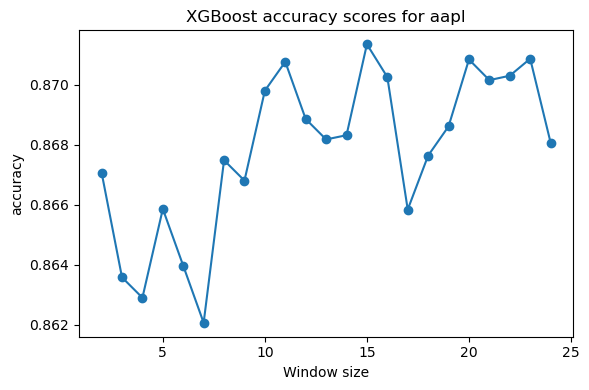

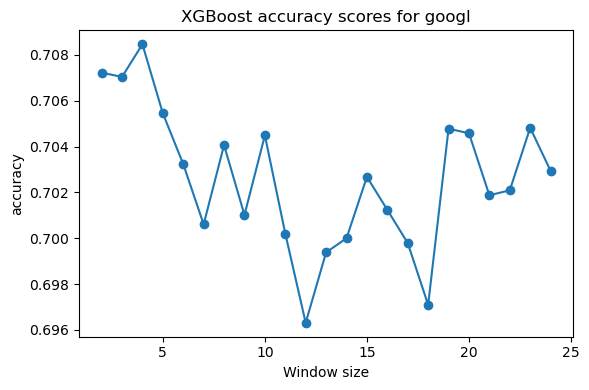

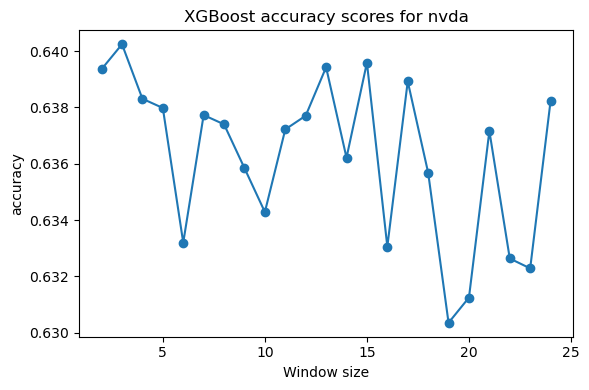

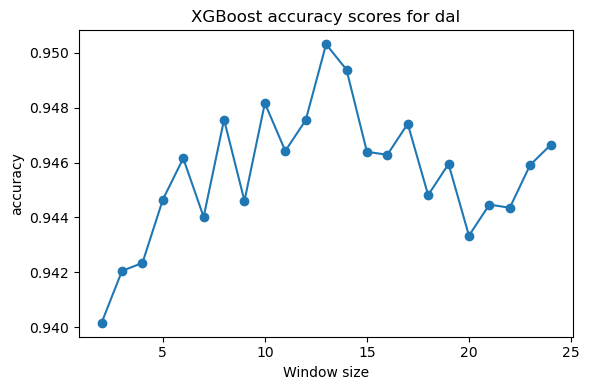

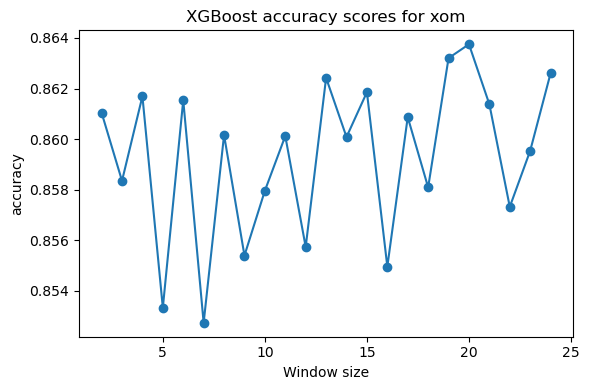

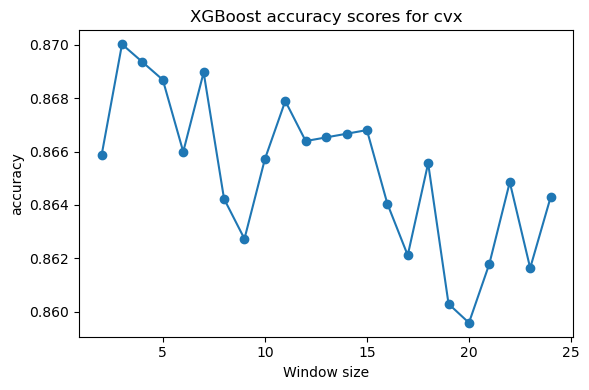

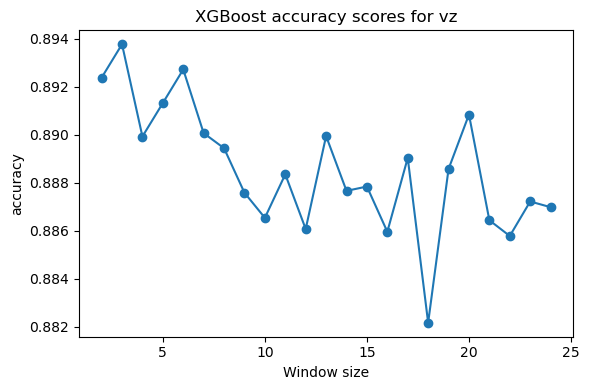

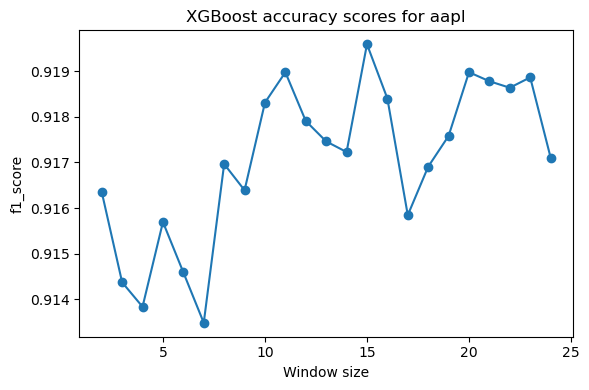

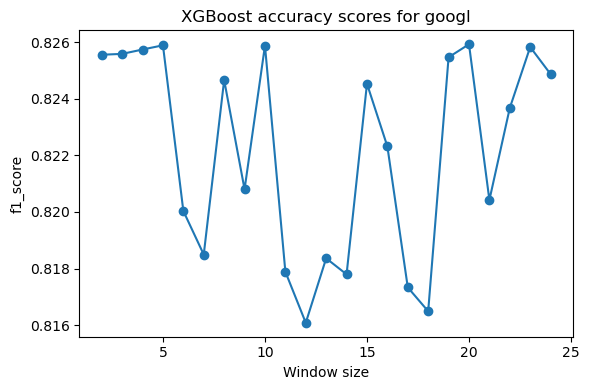

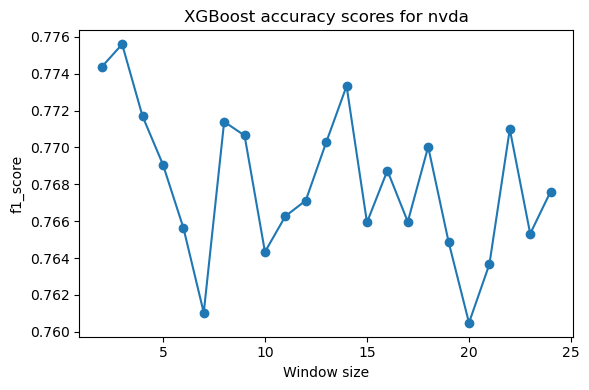

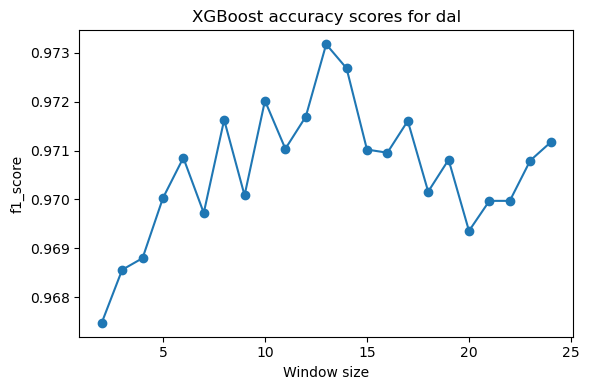

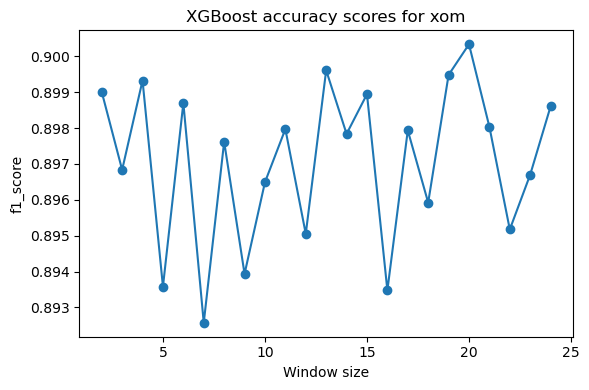

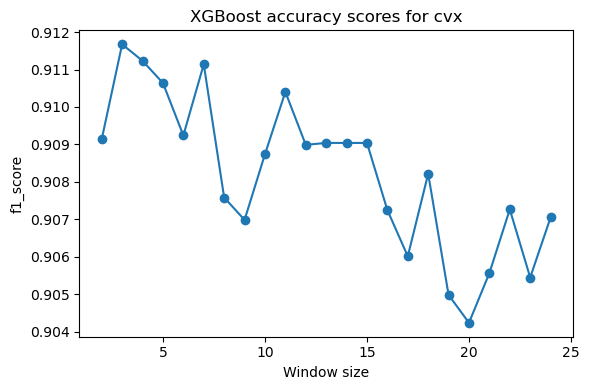

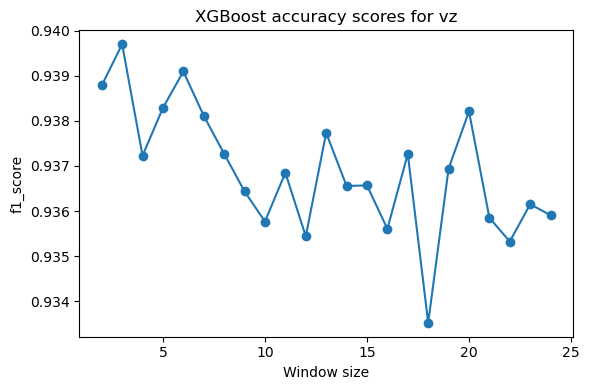

In [22]:
#accuracies_xgb = {}
#for window in spread_range:
#    accuracies_xgb[window] = {}
#    for stock_ind in range(len(stocks)):
#        accuracies_xgb[window][stock_ind] = accuracies_model(best_XGB,window,stock_ind)
accuracies_xgb = {}
confusion_mat_xgb = {}
f1_score_xgb={}
#ada_model = AdaBoostClassifier(n_estimators=100,random_state=121)
for window in spread_range:
    accuracies_xgb[window] = {}
    confusion_mat_xgb[window] = {}
    f1_score_xgb[window]={}
    def helper(i):
        return accuracies_model(best_XGB,window,i)
    pool=multiprocessing.Pool(len(stocks))
    results=list(pool.map(helper, range(len(stocks))))
    for stock_ind in range(len(stocks)):
        accuracies_xgb[window][stock_ind] = results[stock_ind][0]
        confusion_mat_xgb[window][stock_ind] = results[stock_ind][1]
        A=confusion_mat_xgb[window][stock_ind]
        f1_score_xgb[window][stock_ind]=(2*A[0][0]/(2*A[0][0]+A[0][1]+A[1][0]))

plot_accuracies(accuracies_xgb, "XGBoost")
plot_accuracies(f1_score_xgb,"XGBoost",acc_type="f1_score")

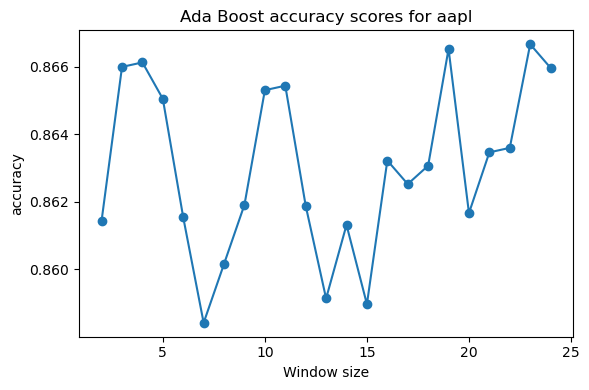

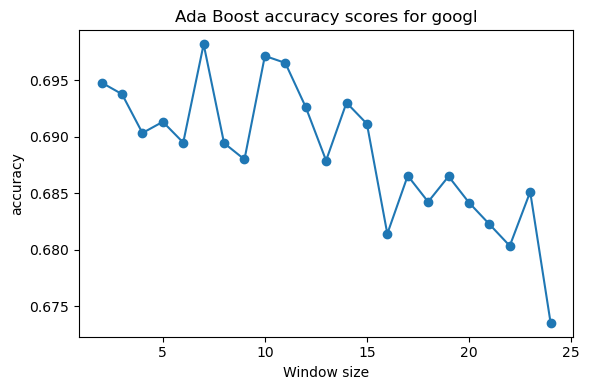

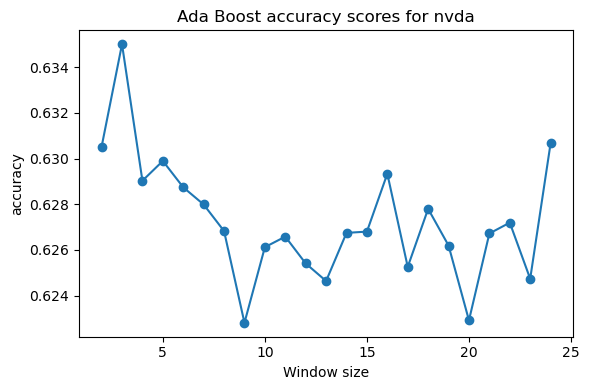

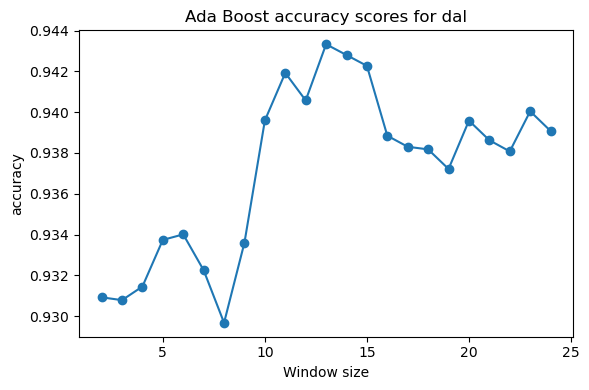

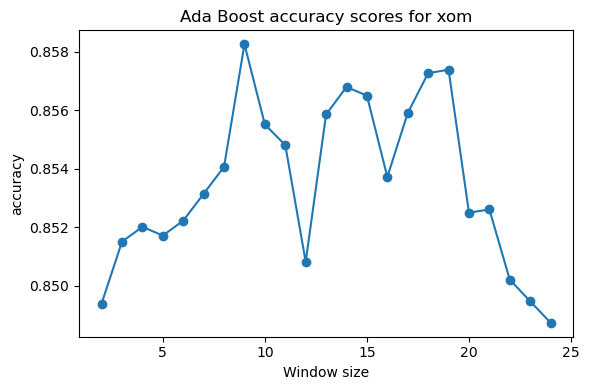

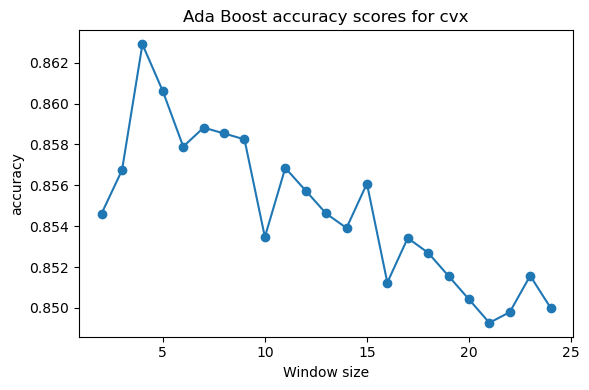

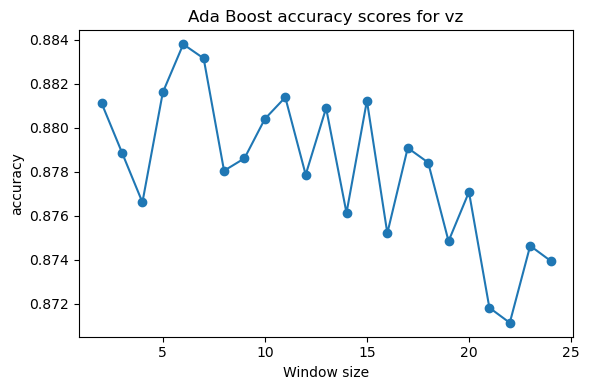

In [17]:
accuracies_ada = {}
for window in spread_range:
    accuracies_ada[window] = {}
    for stock_ind in range(len(stocks)):
        ada_model = AdaBoostClassifier(n_estimators=100,random_state=121)
        accuracies_ada[window][stock_ind] = accuracies_model(ada_model,window,stock_ind,map=False)
plot_accuracies(accuracies_ada, "Ada Boost")

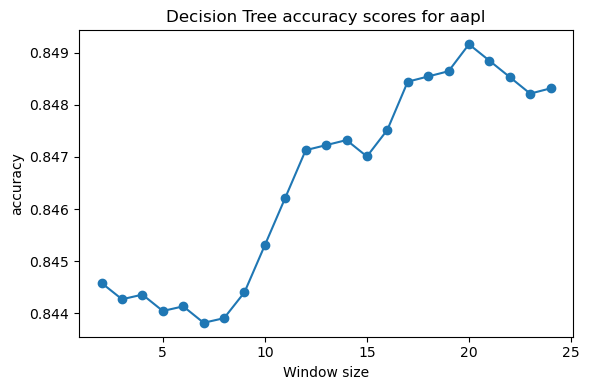

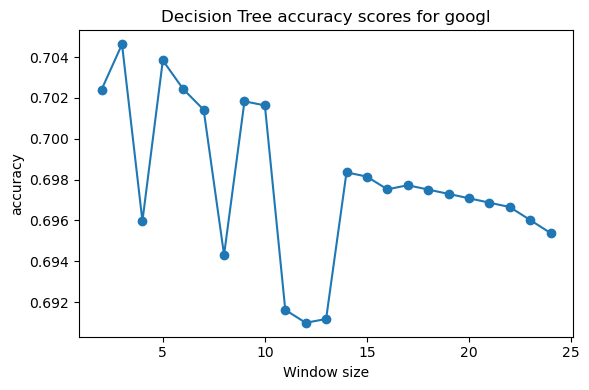

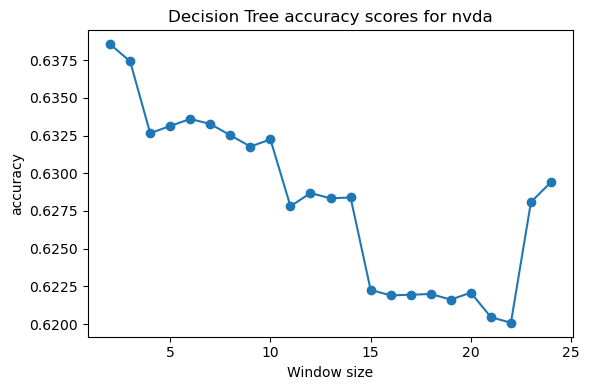

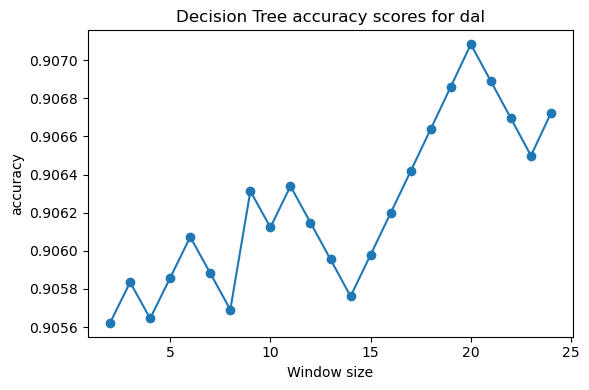

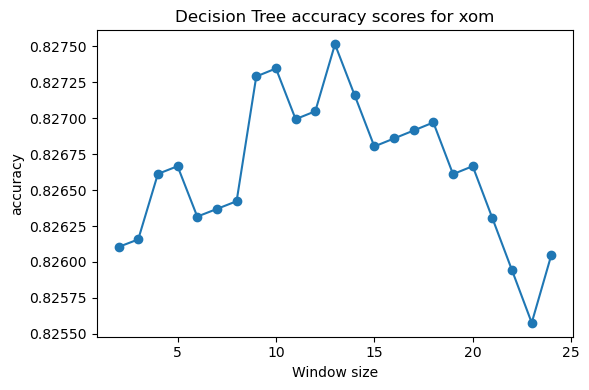

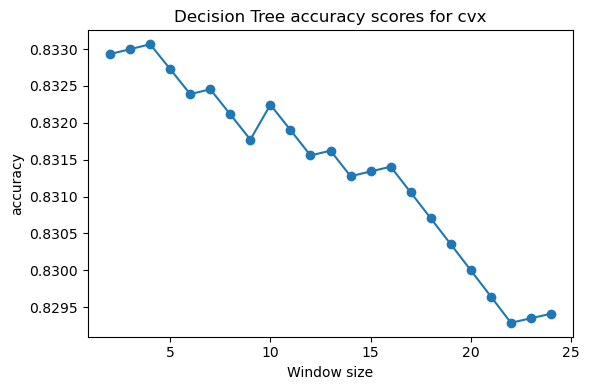

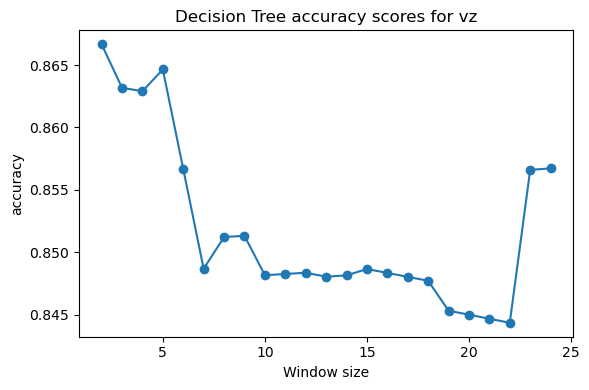

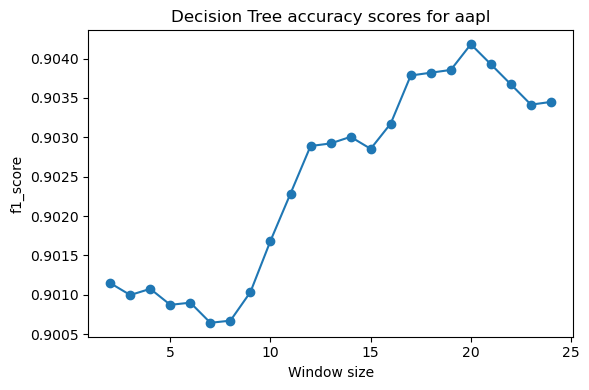

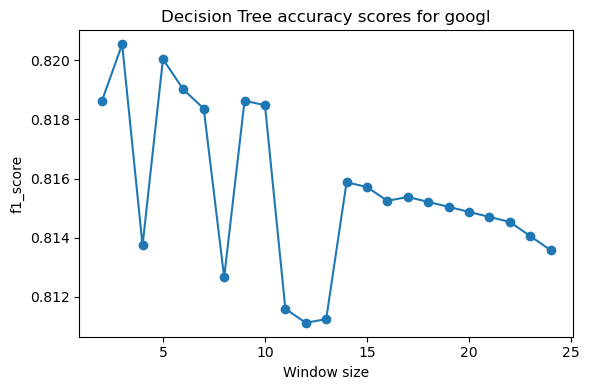

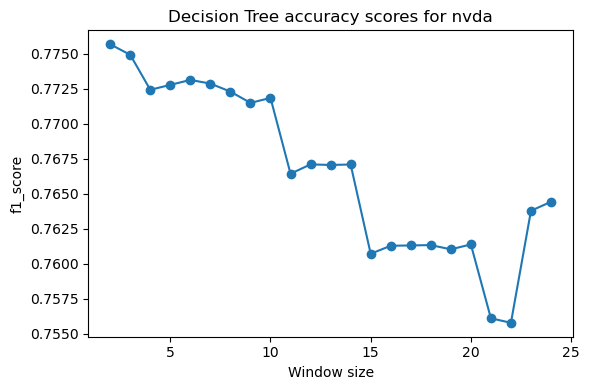

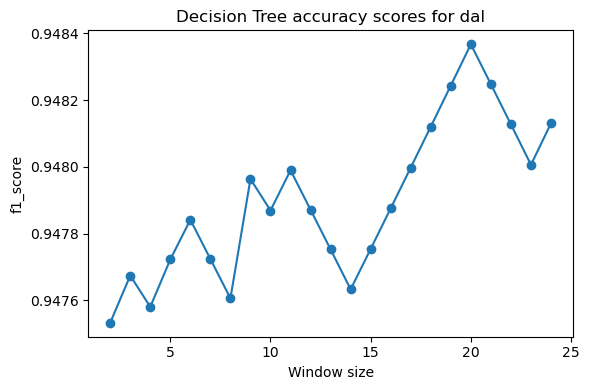

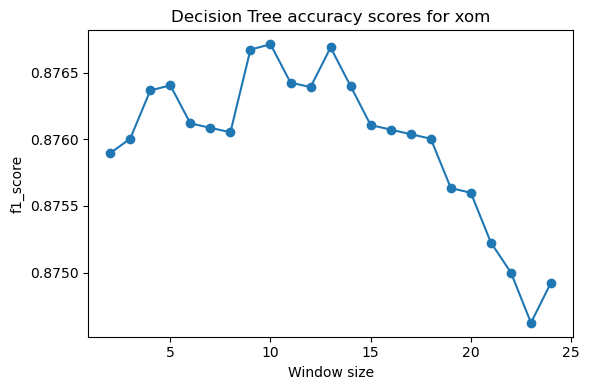

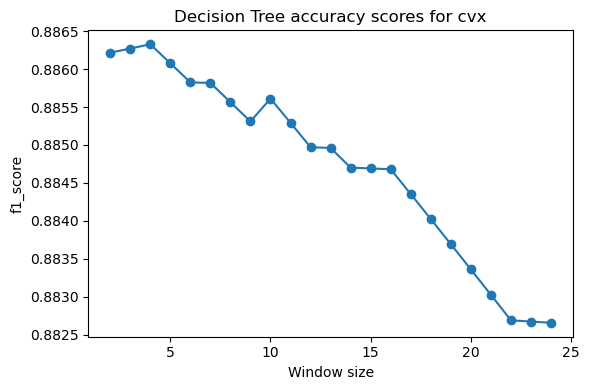

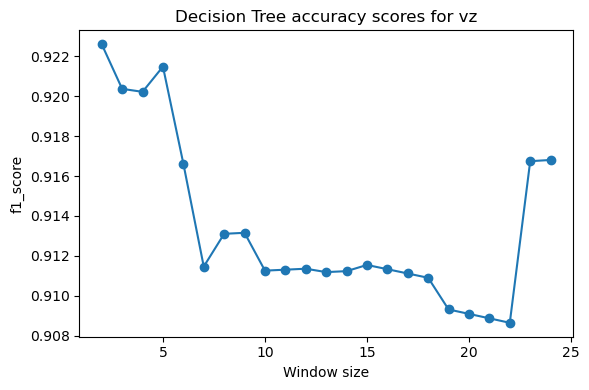

In [23]:

accuracies_dt = {}
confusion_mat_dt = {}
f1_score_dt={}
#ada_model = AdaBoostClassifier(n_estimators=100,random_state=121)
for window in spread_range:
    accuracies_dt[window] = {}
    confusion_mat_dt[window] = {}
    f1_score_dt[window]={}
    decision_model = DecisionTreeClassifier(random_state=rs,max_depth=2)
    def helper(i):
        return accuracies_model(decision_model,window,i,map=False)
    pool=multiprocessing.Pool(len(stocks))
    results=list(pool.map(helper, range(len(stocks))))
    for stock_ind in range(len(stocks)):
        accuracies_dt[window][stock_ind] = results[stock_ind][0]
        confusion_mat_dt[window][stock_ind] = results[stock_ind][1]
        A=confusion_mat_dt[window][stock_ind]
        f1_score_dt[window][stock_ind]=(2*A[0][0]/(2*A[0][0]+A[0][1]+A[1][0]))
plot_accuracies(accuracies_dt, "Decision Tree")
plot_accuracies(f1_score_dt,"Decision Tree", acc_type='f1_score')

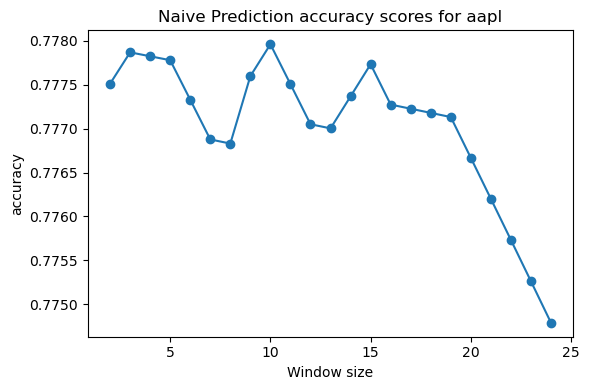

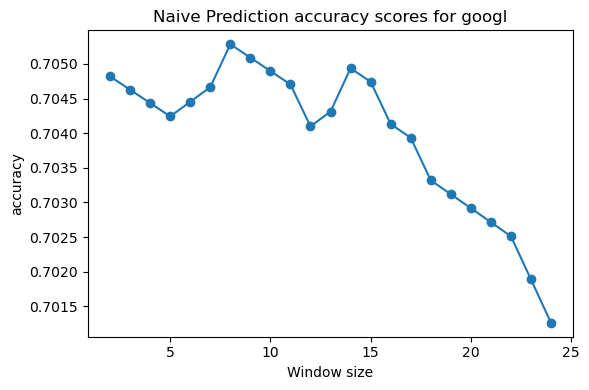

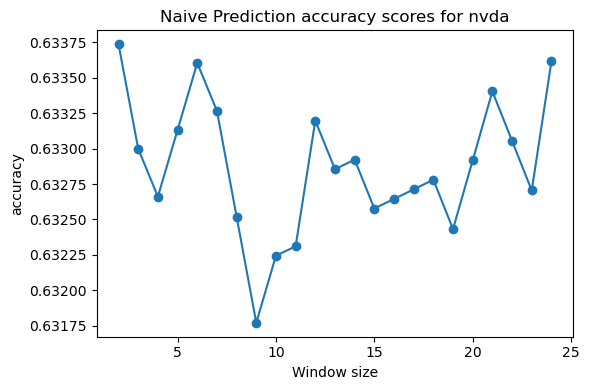

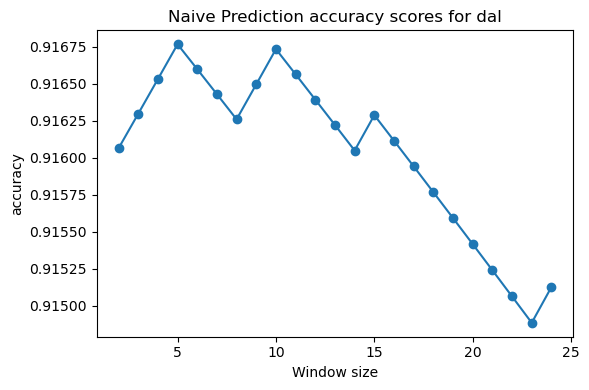

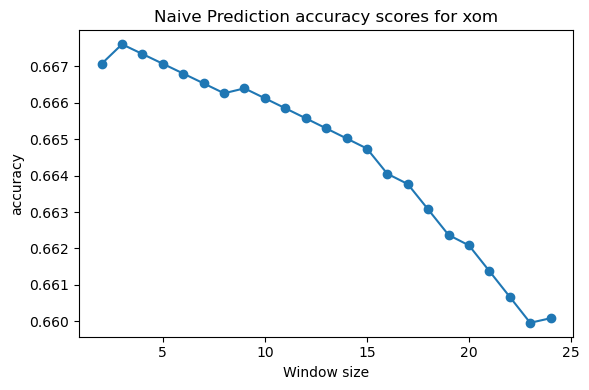

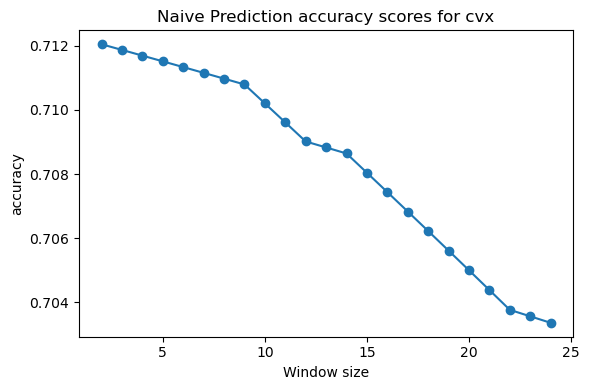

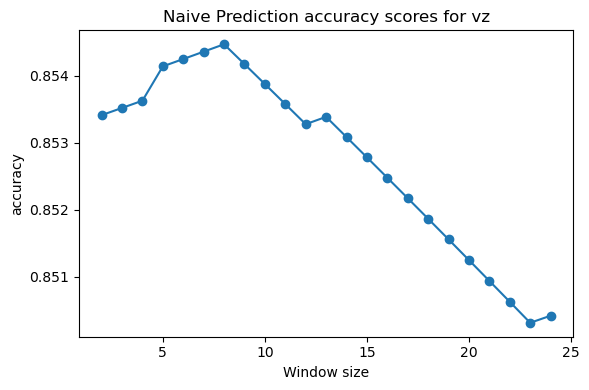

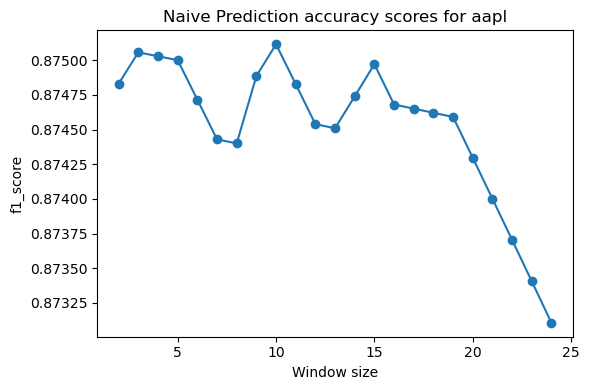

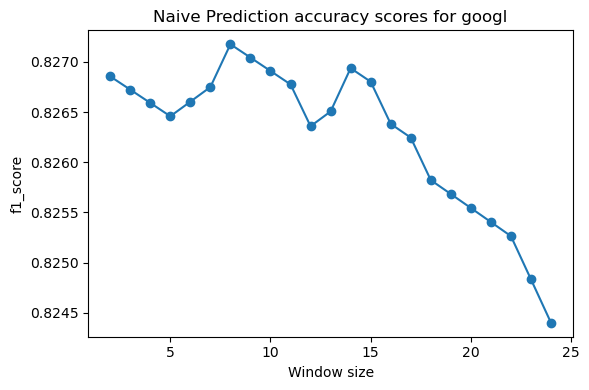

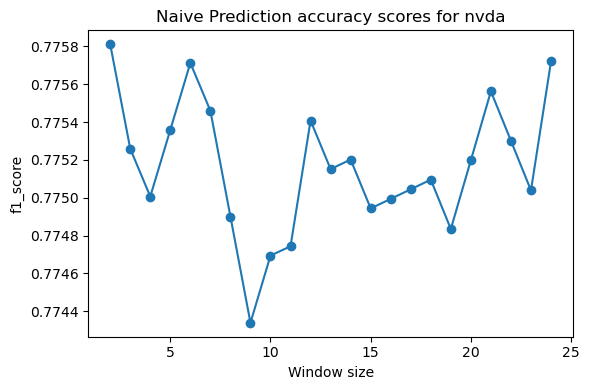

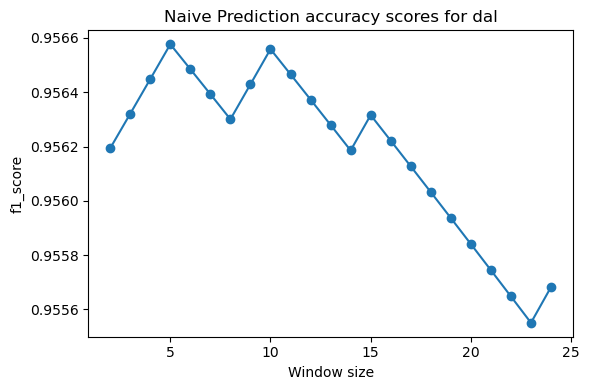

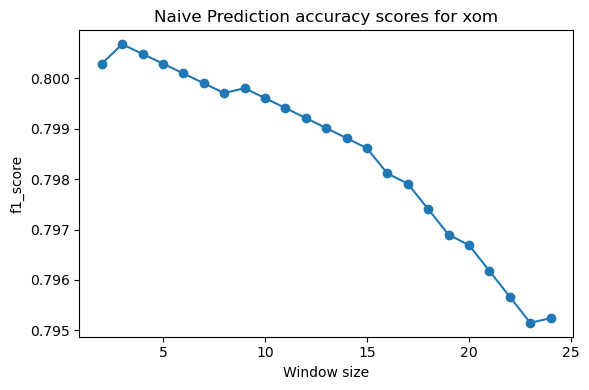

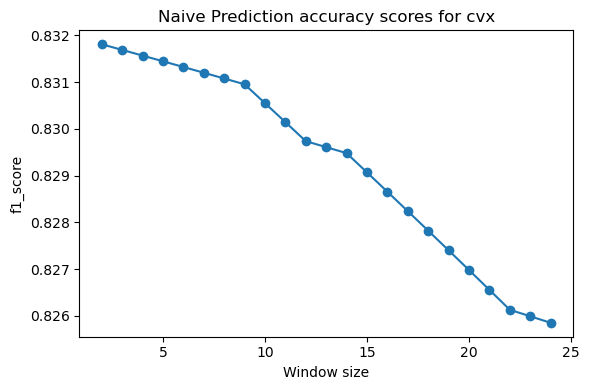

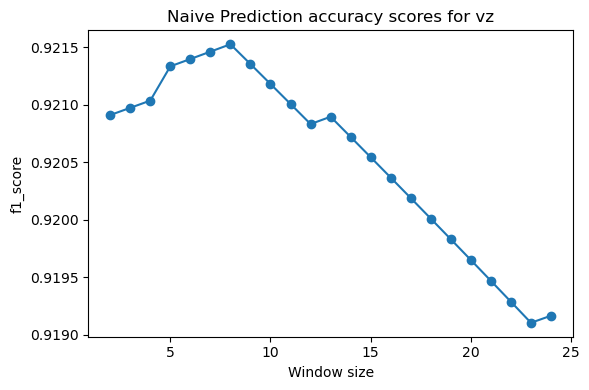

In [26]:
#Naive Prediction
accuracies_naive = {}
confusion_mat_naive={}
f1_score_naive={}
for window in spread_range:
    accuracies_naive[window] = {}
    confusion_mat_naive[window]={}
    f1_score_naive[window]={}
    for s_ind in range(len(stocks)):
        testing_list = testing_lists[window][s_ind]
        testing_list = testing_lists[window][s_ind]
        a=0
        confusion_mat_naive[window][s_ind]=np.zeros((2,2)) 
        for i in range(ns):
            y_pred=[0]*len(testing_list[i][1])
            y_true=testing_list[i][1]
            a+=accuracy_score(y_true,y_pred)
            confusion_mat_naive[window][s_ind]+=confusion_matrix(y_true,y_pred)
        a=a/ns
        accuracies_naive[window][s_ind] = a
        A=confusion_mat_naive[window][s_ind]
        f1_score_naive[window][s_ind]=(2*A[0][0]/(2*A[0][0]+A[0][1]+A[1][0]))
plot_accuracies(accuracies_naive, "Naive Prediction")
plot_accuracies(f1_score_naive, "Naive Prediction",acc_type='f1_score')

In [48]:
accuracies_naive_0 = {}
for window in spread_range:
    accuracies_naive_0[window] = {}
    for s_ind in range(len(stocks)):
        accuracies_naive_0[window][s_ind] = 1 -accuracies_naive[window][s_ind]

In [6]:
from copy import deepcopy
model_forest = RandomForestClassifier(
    n_estimators = 100, # number of trees in ensemble
    max_depth = 10, # max_depth of each tree
    min_samples_leaf = 5, 
    max_features = 5, # default is round(sqrt(num_features)), which in this case is 1.
    random_state = 121 # for consistency
    )

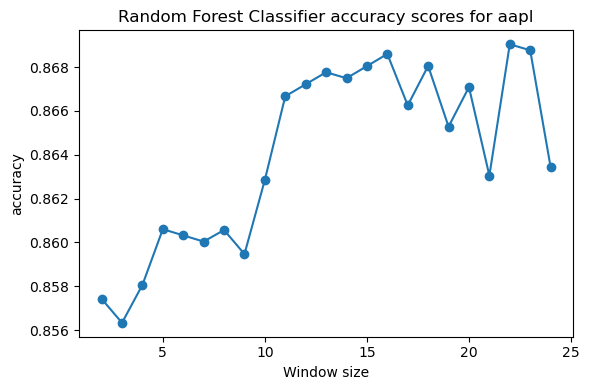

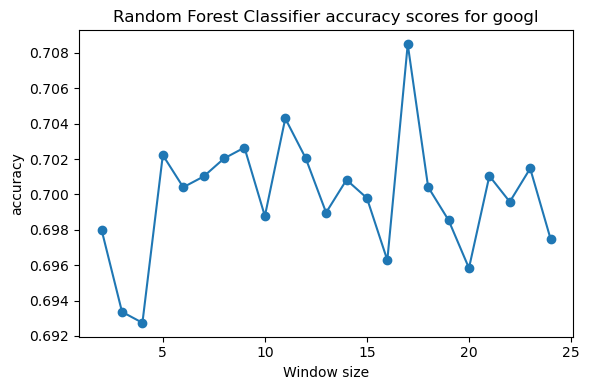

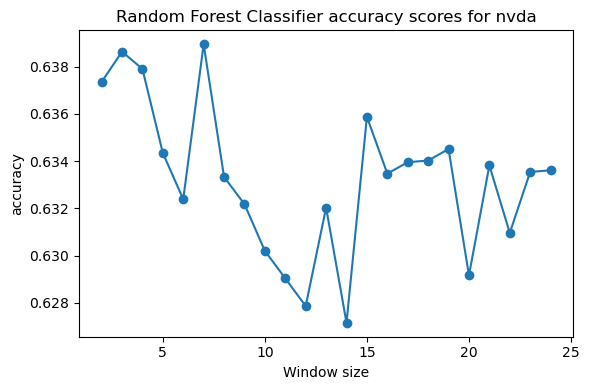

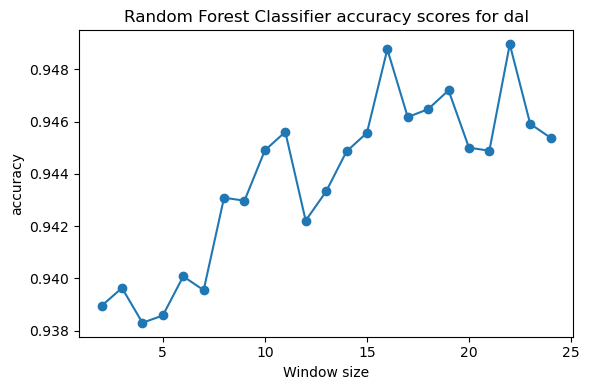

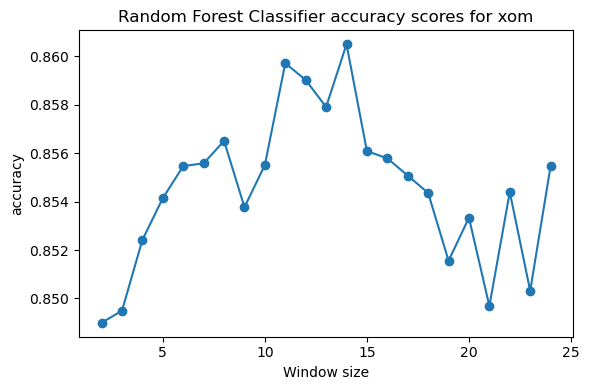

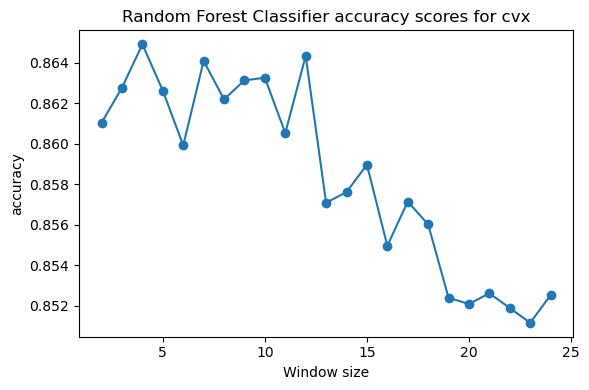

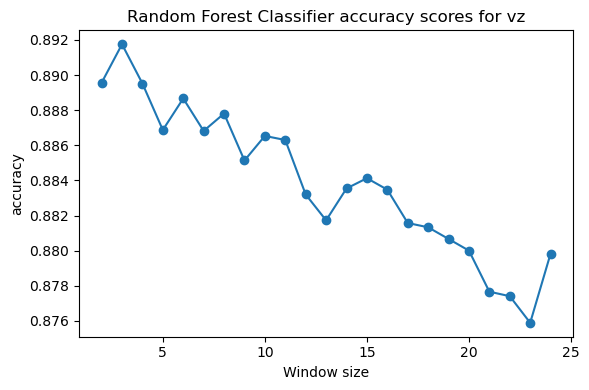

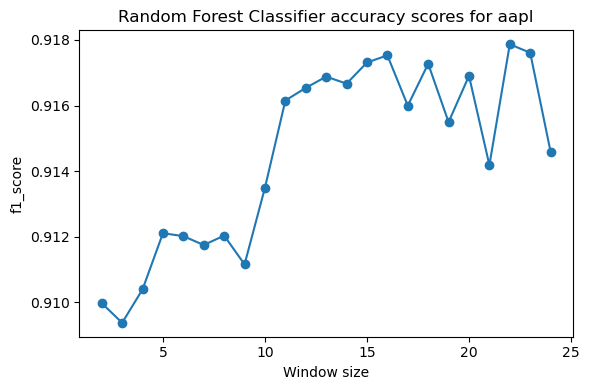

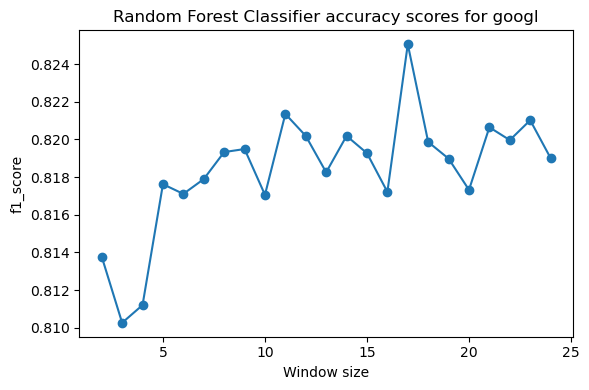

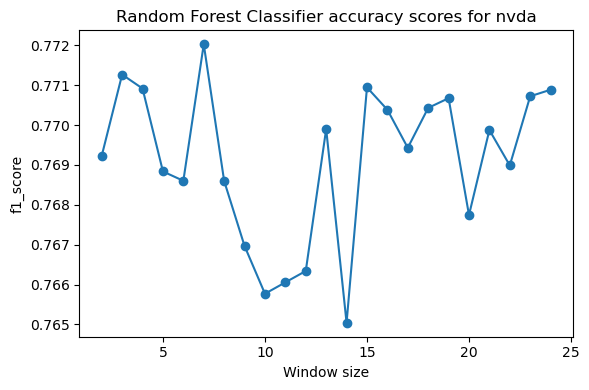

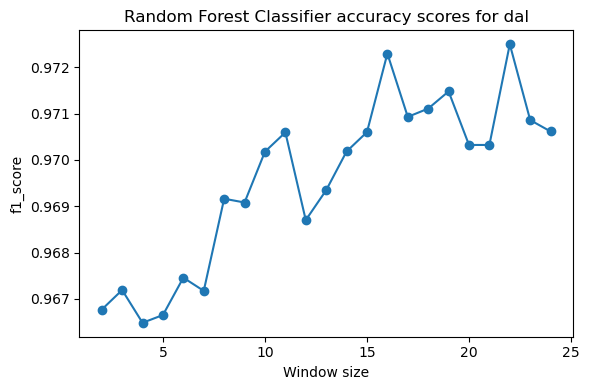

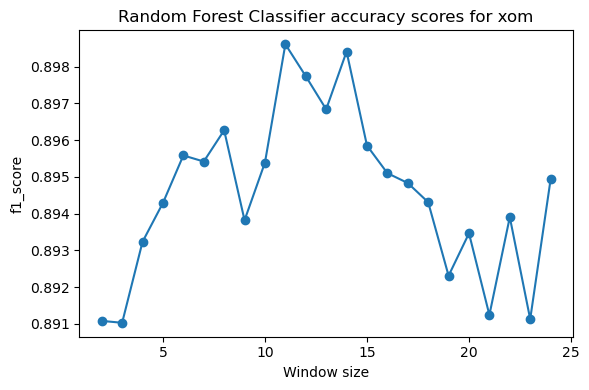

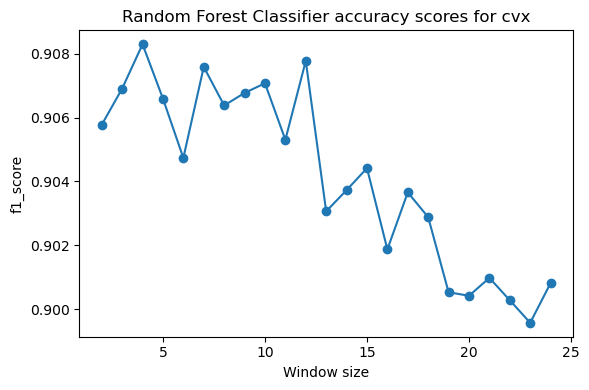

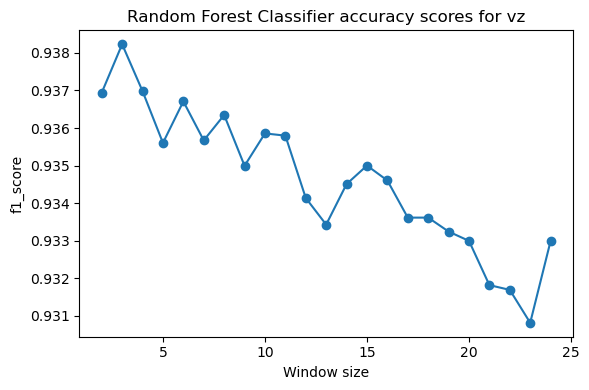

In [16]:
accuracies_rfc = {}
confusion_mat_rfc = {}
f1_score_rfc={}
#ada_model = AdaBoostClassifier(n_estimators=100,random_state=121)
for window in spread_range:
    accuracies_rfc[window] = {}
    confusion_mat_rfc[window] = {}
    f1_score_rfc[window]={}
    def helper(i):
        return accuracies_model(model_forest,window,i,map=False)
    pool=multiprocessing.Pool(len(stocks))
    results=list(pool.map(helper, range(len(stocks))))
    for stock_ind in range(len(stocks)):
        accuracies_rfc[window][stock_ind] = results[stock_ind][0]
        confusion_mat_rfc[window][stock_ind] = results[stock_ind][1]
        A=confusion_mat_rfc[window][stock_ind]
        f1_score_rfc[window][stock_ind]=(2*A[0][0]/(2*A[0][0]+A[0][1]+A[1][0]))
plot_accuracies(accuracies_rfc, "Random Forest Classifier")
plot_accuracies(f1_score_rfc,"Random Forest Classifier", acc_type='f1_score')

In [53]:
accuracies_over_models = [ accuracies_naive_0,accuracies_naive, accuracies_xgb,accuracies_ada,accuracies_decision,accuracies_rfc]
model_names = ["Naive_0","Naive_1","XGBoost","Ada Boosting", "Decision Tree","Random Forest Classifier" ]

In [54]:
best_accs = {}
for stock_ind in range(len(stocks)):
    best_accs[stock_ind] = {}
    for ind, model in enumerate(accuracies_over_models):
        accs_model_windows = [model[window][stock_ind] for window in spread_range]
        max_acc_model = max(accs_model_windows)
        best_accs[stock_ind][ind] = (max_acc_model,spread_range[accs_model_windows.index(max_acc_model)])


In [55]:
data_after_training = {}
data_after_training["Models(rows)/Stocks(columns)"] = model_names
for stock in stocks:
    data_after_training[stock] = []
    for ind, model in enumerate(accuracies_over_models):
        data_after_training[stock].append(best_accs[stocks.index(stock)][ind])
df_test_scores = pd.DataFrame(data_after_training)

In [56]:
df_test_scores

Models(rows)/Stocks(columns)                       aapl  \
0                      Naive_0   (0.7779591836734694, 10)   
1                      Naive_1  (0.22521008403361345, 24)   
2                      XGBoost   (0.8739219712525668, 13)   
3                 Ada Boosting   (0.8666666666666666, 23)   
4                Decision Tree   (0.7941299790356393, 23)   
5     Random Forest Classifier   (0.8690376569037659, 22)   

                      googl                      nvda  \
0   (0.7052845528455285, 8)   (0.6337349397590362, 2)   
1  (0.2987394957983193, 24)  (0.36822810590631366, 9)   
2   (0.7080645161290324, 4)   (0.6426559356136822, 3)   
3   (0.6981744421906693, 7)    (0.635010060362173, 3)   
4  (0.6024590163934427, 12)   (0.5565392354124749, 3)   
5  (0.7084886128364389, 17)   (0.6389452332657201, 7)   

                         dal                       xom  \
0    (0.9167676767676768, 5)   (0.6676056338028169, 3)   
1  (0.08511530398322852, 23)   (0.340041928721174, 23)   
2   (0.9506122448979593, 10)  (0.8633123689727464, 23)   
3   (0.9433264887063654, 13)   (0.8582484725050918, 9)   
4   (0.8950617283950617, 14)   (0.7919517102615694, 3)   
5   (0.9489539748953975, 22)  (0.8604938271604938, 14)   

                        cvx                         vz  
0   (0.7120481927710843, 2)    (0.8544715447154472, 8)  
1  (0.2966386554621849, 24)  (0.14968553459119496, 23)  
2    (0.871919191919192, 5)    (0.8943775100401605, 2)  
3   (0.8629032258064516, 4)    (0.8838056680161943, 6)  
4   (0.8036511156186611, 7)    (0.8277665995975856, 3)  
5   (0.8649193548387097, 4)    (0.8917505030181087, 3)